In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import seaborn as sns
from textblob import TextBlob


# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/seattle/calendar.csv
/kaggle/input/seattle/listings.csv
/kaggle/input/seattle/reviews.csv


**Step 1: Importing the data**

In [2]:
calendar = pd.read_csv('/kaggle/input/seattle/calendar.csv')
listing = pd.read_csv('/kaggle/input/seattle/listings.csv')
review = pd.read_csv('/kaggle/input/seattle/reviews.csv')

**Step 2: Cleaning the data**
Types of data need to clean: 
    - Missing Values
    - Data Type Conversion
    - Inconsistent Formatting
    - Duplicate Data
    - Inaccurate Data

In [3]:
# Remove NA Values and $ Sign From Price
calendar['price'] = pd.to_numeric(calendar['price'].replace('[\$,]', '', regex=True), errors='coerce')
calendar.dropna(subset=['price'], inplace=True)
print(calendar)

         listing_id        date available  price
0            241032  2016-01-04         t   85.0
1            241032  2016-01-05         t   85.0
9            241032  2016-01-13         t   85.0
10           241032  2016-01-14         t   85.0
14           241032  2016-01-18         t   85.0
...             ...         ...       ...    ...
1393207    10208623  2016-01-06         t   87.0
1393208    10208623  2016-01-07         t   87.0
1393211    10208623  2016-01-10         t   87.0
1393212    10208623  2016-01-11         t   87.0
1393213    10208623  2016-01-12         t   87.0

[934542 rows x 4 columns]


In [4]:
# Save Cleaned Data
calendar.to_csv('calender.csv', index=False)

**Step 3: Analyze the data**

1. Pricing Trends Over Time

In [5]:
# Convert the 'date' column to datetime format
calendar['date'] = pd.to_datetime(calendar['date'])

In [6]:
# Extract month and year from the 'date' column
calendar['month'] = calendar['date'].dt.month
calendar['year'] = calendar['date'].dt.year

# Calculate the average price per night for each month
average_price_per_month = calendar.groupby(['year', 'month'])['price'].mean()

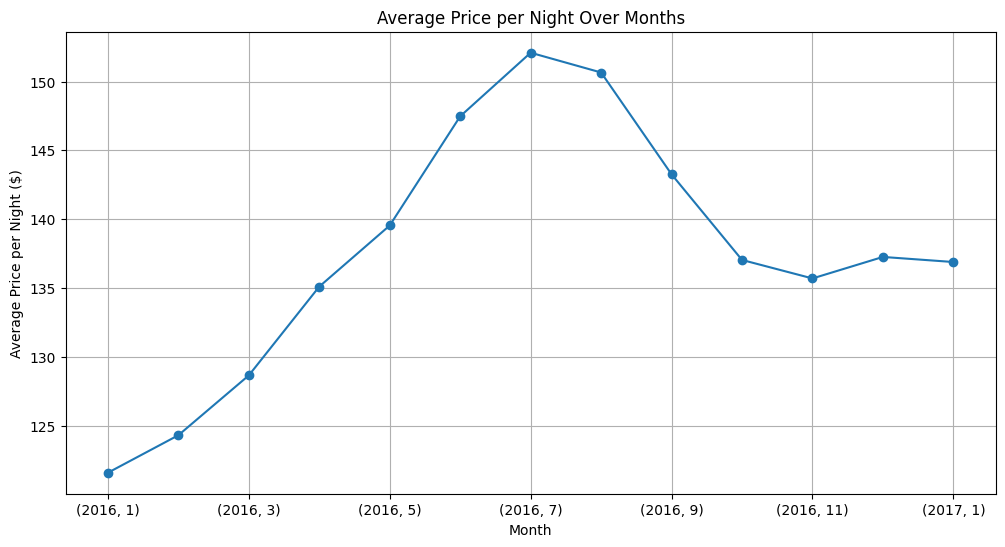

In [7]:
# Plotting
plt.figure(figsize=(12, 6))
average_price_per_month.plot(marker='o', linestyle='-')
plt.title('Average Price per Night Over Months')
plt.xlabel('Month')
plt.ylabel('Average Price per Night ($)')
plt.grid(True)
plt.show()

2. Popular Neighborhoods

The neighborhood name is embedded within a longer description in the "neighborhood" column, and neighborhood
information varies in each row and is not consistently positioned at the beginning or end of the description.
A way to approach this creating a dictionary that contains all the popular neighborhoods and check for their 
presnece in each row. 

In [8]:
# List of known neighborhoods
known_neighborhoods = ['Queen Anne', 'Capitol Hill', 'Ballard', 'Fremont', 'West Seattle','Downtown',
                      'Beacon Hill', 'Central District', 'Belltown', 'Montlake', 'Mount Bake', 'Wallingford',
                      'Green Lake', 'Madrona', 'Madison', 'University District', 'South Lake', 'Eastlake']

In [9]:
# Function to find the neighborhood in the description
def find_neighborhood(description):
    if pd.notna(description):
        for neighborhood in known_neighborhoods:
            if neighborhood.lower() in description.lower():
                return neighborhood
    
# Apply the function to create a new 'Neighborhood' column
listing['Neighborhood'] = listing['neighbourhood'].apply(find_neighborhood)

# Count the number of listings in each neighborhood
neighborhood_counts = listing['Neighborhood'].value_counts().reset_index()

# Rename the columns for clarity
neighborhood_counts.columns = ['Neighborhood', 'Number of Listings']

# Sort the neighborhoods by the number of listings in descending order
neighborhood_counts = neighborhood_counts.sort_values(by='Number of Listings', ascending=False)

# Display the distribution of listings across neighborhoods
print(neighborhood_counts)

           Neighborhood  Number of Listings
0          Capitol Hill                 351
1            Queen Anne                 270
2               Ballard                 213
3              Belltown                 204
4               Fremont                 148
5           Wallingford                 143
6   University District                 107
7           Beacon Hill                  97
8            Green Lake                  52
9            Mount Bake                  46
10             Eastlake                  41
11              Madrona                  40
12           South Lake                  21
13             Montlake                  19
14              Madison                  16


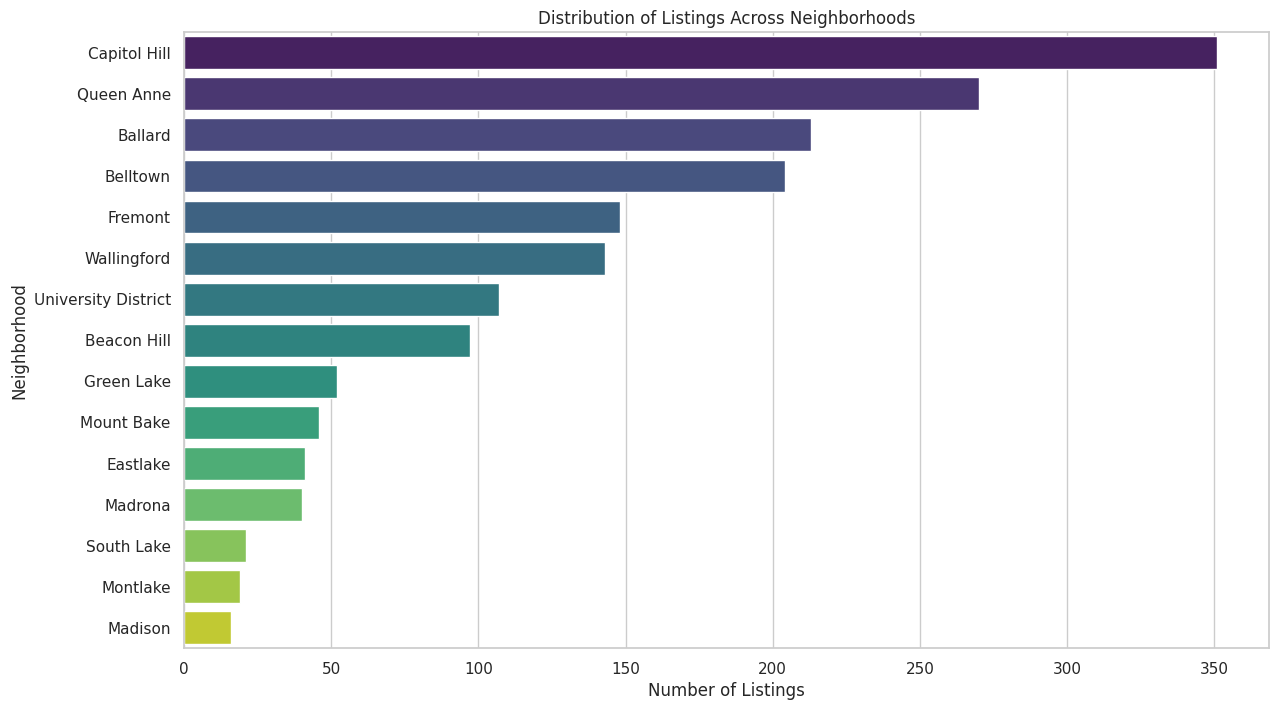

In [10]:
# Create Graph
sns.set(style="whitegrid")
plt.figure(figsize=(14, 8))
sns.barplot(x='Number of Listings', y='Neighborhood', data=neighborhood_counts, palette='viridis')
plt.title('Distribution of Listings Across Neighborhoods')
plt.xlabel('Number of Listings')
plt.ylabel('Neighborhood')
plt.show()

3. Review Sentiment Analysis:

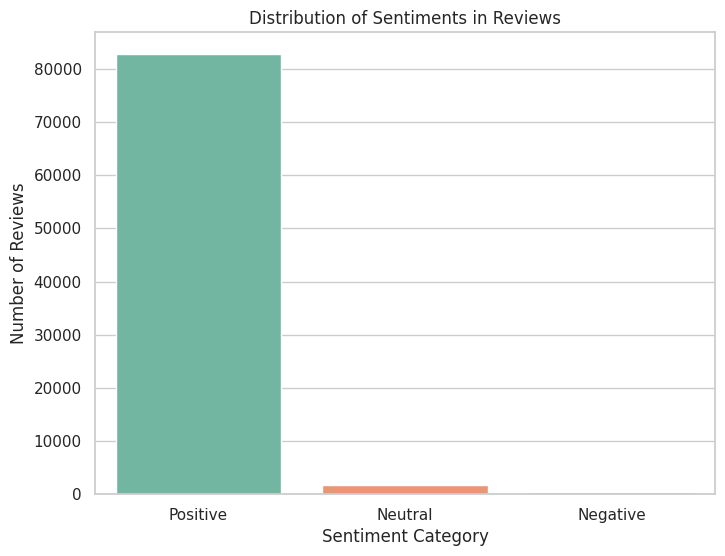

Sentiment_Catagory
Positive    97.534444
Neutral      1.981167
Negative     0.484390
Name: proportion, dtype: float64


In [11]:
# Convert 'comments' column to strings to handle NaN values
review['comments'] = review['comments'].astype(str)

# Fumction to get sentiment polarity
def get_sentiment(comment):
    return TextBlob(comment).sentiment.polarity

# Apply sentiment function to each comment
review['Sentiment'] = review['comments'].apply(get_sentiment)

# Categorize reviews as positive, negative, or neutral
review['Sentiment_Catagory'] = review['Sentiment'].apply(lambda x: 'Positive' if x > 0 else 'Negative' if x < 0
                                                        else 'Neutral')
# Plotting
plt.figure(figsize=(8, 6))
sns.countplot(x='Sentiment_Catagory', data=review, palette='Set2')
plt.title('Distribution of Sentiments in Reviews')
plt.xlabel('Sentiment Category')
plt.ylabel('Number of Reviews')
plt.show()

# Display the percentage of positive and negative sentiments
sentiment_percentage = review['Sentiment_Catagory'].value_counts(normalize=True) * 100
print(sentiment_percentage)